# The XOR dataset

Creating XOR dataset:

In [1]:
import numpy as np

n_per_corner=25
sigma=0.05

X_00 = np.random.normal([0,0], sigma, size=(n_per_corner,2))
y_00 = np.repeat(0, n_per_corner)
X_11 = np.random.normal([1,1], sigma, size=(n_per_corner,2))
y_11 = np.repeat(0, n_per_corner)

X_01 = np.random.normal([0,1], sigma, size=(n_per_corner,2))
y_01 = np.repeat(1, n_per_corner)
X_10 = np.random.normal([1,0], sigma, size=(n_per_corner,2))
y_10 = np.repeat(1, n_per_corner)

Look at the dataset: 

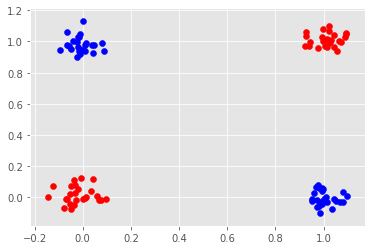

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.scatter(X_00[:,0], X_00[:,1], color='r')
plt.scatter(X_11[:,0], X_11[:,1], color='r')
plt.scatter(X_01[:,0], X_01[:,1], color='b')
plt.scatter(X_10[:,0], X_10[:,1], color='b')

The red point belongs to class 0 and the blue points belongs to class 1. One can easily split the points by drawing following lines:

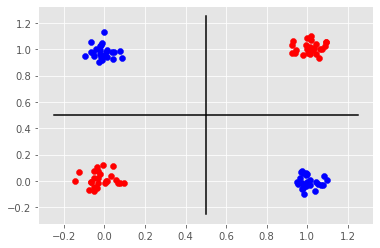

In [3]:
plt.scatter(X_00[:,0], X_00[:,1], color='r')
plt.scatter(X_11[:,0], X_11[:,1], color='r')
plt.scatter(X_01[:,0], X_01[:,1], color='b')
plt.scatter(X_10[:,0], X_10[:,1], color='b')
plt.plot([0.5, 0.5], [-0.25, 1.25], 'k-', color = 'k')
plt.plot([-0.25, 1.25], [0.5, 0.5], 'k-', color = 'k')

# Fitting a decision tree

The model that should easily be able to do that is a simple decision tree. These models always split the pace into linear partitions. First define a method to create the dataset. 

In [4]:
def get_XOR_dataset(n_per_corner, sigma):
    X_00 = np.random.normal([0,0], sigma, size=(n_per_corner,2))
    y_00 = np.repeat(0, n_per_corner)
    X_11 = np.random.normal([1,1], sigma, size=(n_per_corner,2))
    y_11 = np.repeat(0, n_per_corner)
    
    X_01 = np.random.normal([0,1], sigma, size=(n_per_corner,2))
    y_01 = np.repeat(1, n_per_corner)
    X_10 = np.random.normal([1,0], sigma, size=(n_per_corner,2))
    y_10 = np.repeat(1, n_per_corner)
    
    X = np.concatenate((X_00, X_11, X_01, X_10))
    y= np.concatenate((y_00, y_11, y_01, y_10))
    return X, y

Now fit split the data set into a train and validation set and fit a decision tree. 

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

np.random.seed(0)
X, y = get_XOR_dataset(n_per_corner=1000, sigma=0.1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=123)

max_leaf_nodes = 4
model = DecisionTreeClassifier(random_state=0, max_leaf_nodes=max_leaf_nodes).fit(X_train, y_train)

y_prob_val = model.predict_proba(X_val)[:,1]
y_prob_train = model.predict_proba(X_train)[:,1]

Look at the performance of the tree. I received the ratios of each leaf, so using a threshold of 0.5 gives me a majority vote of the class that the tree predicts. 

In [6]:
from sklearn.metrics import accuracy_score

y_pred = np.where(y_prob_val > 0.5, 1, 0)
accuracy = accuracy_score(y_true=y_val, y_pred=y_pred)
print(accuracy)

0.547


Look at the tree. 

[Text(279.0, 226.5, 'X[0] <= 1.118\ngini = 0.5\nsamples = 3000\nvalue = [1499, 1501]'),
 Text(139.5, 135.9, 'X[1] <= 0.963\ngini = 0.5\nsamples = 2838\nvalue = [1435, 1403]'),
 Text(69.75, 45.29999999999998, 'gini = 0.498\nsamples = 1912\nvalue = [1020, 892]'),
 Text(209.25, 45.29999999999998, 'gini = 0.495\nsamples = 926\nvalue = [415, 511]'),
 Text(418.5, 135.9, 'X[1] <= 0.497\ngini = 0.478\nsamples = 162\nvalue = [64, 98]'),
 Text(348.75, 45.29999999999998, 'gini = 0.0\nsamples = 98\nvalue = [0, 98]'),
 Text(488.25, 45.29999999999998, 'gini = 0.0\nsamples = 64\nvalue = [64, 0]')]

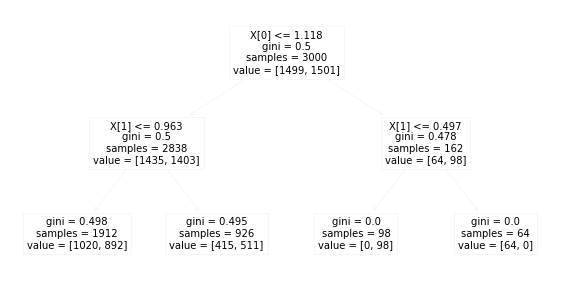

In [7]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10,5))
                                   
plot_tree(model, fontsize=10)

The tree is not able to learn the data. This is because of the formulation of the loss function along with the optimization algorithm. If the tree would do the splits accoring to the drawn lines, the first line (either horizontal or vertical) would be the wost split according to the gini impurity. Hence the model can not learn the splits, at least with this setting (max_leaf = 4 and no pruning).

# Fitting a multilayer neural network

Defining the model according *Deep Learning, Goodfellow-et-al-2016* equation 6.3:

In [8]:
import torch.nn as nn
import torch

class NN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NN, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.fc1 = nn.Linear(self.input_size,self.hidden_size)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(self.hidden_size, 1)         

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        hidden1 = self.fc1(x)
        relu1 = self.relu1(hidden1)

        output = self.fc2(relu1)
        output = self.sigmoid(output)
        return output

Defining the training.

In [9]:
def training(model, X_train_T, y_train_T, lr,  n_epochs):
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)    
    
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        y_pred = model(X_train_T)
        loss = criterion(y_pred.squeeze(), y_train_T)
      
        #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        
        loss.backward()
        optimizer.step()

Converting `numpy` arrays to `pytorch` tensors.

In [10]:
X_train_T = torch.from_numpy(X_train).float()
y_train_T = torch.from_numpy(y_train).float()  
X_val_T = torch.from_numpy(X_val).float()

torch.manual_seed(848)

model = NN(input_size=2, hidden_size=2)

training(model, X_train_T, y_train_T, lr = 1, n_epochs=120)

Evaluate the performance:

In [11]:
model.eval()
with torch.no_grad():
    y_prob_val = model.forward(X_val_T).view(-1).detach().numpy()

y_pred = np.where(y_prob_val > 0.5, 1, 0)
accuracy = accuracy_score(y_true=y_val, y_pred=y_pred)
print(accuracy)

1.0


Because the parameters are learned with numerical optimization, the accuracy will change if I change the seed. In the book the parameters as determinded "by hand".